In [2]:
import csv
import numpy as np
import os
import keras
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics

In [3]:
base_dir = 'creditcard.csv'

In [4]:
all_features = []
all_targets = []

with open(base_dir) as d:
    for i , line in enumerate(d):
        if i == 0:
            continue

        fields = line.strip().split(",")
        all_features.append([float(v.replace('"', "")) for v in fields[:-1]])
        all_targets.append([int(fields[-1].replace('"', ""))])

features = np.array(all_features, dtype="float32")
targets = np.array(all_targets, dtype="uint8")
print("features.shape:", features.shape)
print("targets.shape:", targets.shape)

features.shape: (284807, 30)
targets.shape: (284807, 1)


In [4]:
train_features ,test_features ,train_targets ,test_targets = train_test_split(features ,
                                                                            targets , test_size=0.2 , random_state=42)
test_features ,val_features ,test_targets ,val_targets = train_test_split(test_features ,
                                                                              test_targets , test_size=0.5 , random_state=42)

In [5]:
print("Number of training samples:", len(train_features))
print("Number of validation samples:", len(val_features))
print("Number of test samples:", len(test_features))

Number of training samples: 227845
Number of validation samples: 28481
Number of test samples: 28481


In [6]:
counts = np.bincount(train_targets[:, 0])
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(train_targets)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

Number of positive samples in training data: 394 (0.17% of total)


In [7]:
train_features = train_features.astype('float32')
train_targets = train_targets.astype('float32')
val_features = val_features.astype('float32')
val_targets = val_targets.astype('float32')
test_features = test_features.astype('float32')
test_targets = test_targets.astype('float32')

In [8]:
train_targets = tf.one_hot(train_targets , depth=2)
val_targets = tf.one_hot(val_targets , depth=2)
test_targets = tf.one_hot(test_targets , depth=2)


2024-05-10 12:00:21.268364: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 12:00:21.286560: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 12:00:21.286794: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [9]:
train_targets = tf.squeeze(train_targets)
val_targets = tf.squeeze(val_targets)
test_targets = tf.squeeze(test_targets)

In [10]:
mean = np.mean(train_features, axis=0)
train_features -= mean
val_features -= mean
test_features -= mean
std = np.std(train_features, axis=0)
train_features /= std
val_features /= std
test_features /= std


In [11]:
model_weight = keras.Sequential(
    [
        keras.Input(shape=train_features.shape[1:]),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(2),
    ]
)
model_weight.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7936      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 74242 (290.01 KB)
Trainable params: 74242 (290.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
model = keras.Sequential(
    [
        keras.Input(shape=train_features.shape[1:]),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(2),
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               7936      
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                                 
Total params: 74242 (290.01 KB)
Trainable params: 74242 (290.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
metrics1 = [
    keras.metrics.F1Score(name="f1_score"),
]

In [14]:
model_weight.compile(
        optimizer=keras.optimizers.Adam(1e-3), loss=tf.losses.CategoricalCrossentropy(from_logits=True), metrics=metrics1 , 
)

class_weight = {0: weight_for_0, 1: weight_for_1}


In [15]:
class_weight

{0: 4.396551345124884e-06, 1: 0.0025380710659898475}

In [16]:
model_weight.fit(
    train_features,
    train_targets,
    batch_size=2048,
    epochs=10,
    verbose=2,
    validation_data=(val_features, val_targets),
    class_weight=class_weight
)

Epoch 1/10


2024-05-10 12:00:22.053764: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-10 12:00:22.767229: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe3589bf120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-10 12:00:22.767259: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce MX330, Compute Capability 6.1
2024-05-10 12:00:22.771969: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-10 12:00:22.783461: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1715356822.840964    4564 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


112/112 - 2s - loss: 3.5676e-06 - f1_score: 0.4308 - val_loss: 0.2500 - val_f1_score: 0.6091 - 2s/epoch - 20ms/step
Epoch 2/10
112/112 - 1s - loss: 1.8825e-06 - f1_score: 0.5596 - val_loss: 0.1821 - val_f1_score: 0.5481 - 566ms/epoch - 5ms/step
Epoch 3/10
112/112 - 1s - loss: 1.5664e-06 - f1_score: 0.5433 - val_loss: 0.1968 - val_f1_score: 0.5206 - 572ms/epoch - 5ms/step
Epoch 4/10
112/112 - 1s - loss: 1.3823e-06 - f1_score: 0.5447 - val_loss: 0.1406 - val_f1_score: 0.5327 - 579ms/epoch - 5ms/step
Epoch 5/10
112/112 - 1s - loss: 1.3824e-06 - f1_score: 0.5409 - val_loss: 0.0861 - val_f1_score: 0.5727 - 580ms/epoch - 5ms/step
Epoch 6/10
112/112 - 1s - loss: 1.1649e-06 - f1_score: 0.5629 - val_loss: 0.1364 - val_f1_score: 0.5238 - 576ms/epoch - 5ms/step
Epoch 7/10
112/112 - 1s - loss: 1.1917e-06 - f1_score: 0.5478 - val_loss: 0.1332 - val_f1_score: 0.5215 - 579ms/epoch - 5ms/step
Epoch 8/10
112/112 - 1s - loss: 1.0593e-06 - f1_score: 0.5479 - val_loss: 0.0912 - val_f1_score: 0.5461 - 575m

In [17]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3), loss=tf.losses.CategoricalCrossentropy(from_logits=True), metrics=metrics1
)

In [18]:
model.fit(
    train_features,
    train_targets,
    batch_size=2048,
    epochs=10,
    verbose=2,
    validation_data=(val_features, val_targets),
)

Epoch 1/10
112/112 - 1s - loss: 0.0350 - f1_score: 0.5426 - val_loss: 0.0049 - val_f1_score: 0.8814 - 1s/epoch - 11ms/step
Epoch 2/10
112/112 - 1s - loss: 0.0046 - f1_score: 0.8847 - val_loss: 0.0033 - val_f1_score: 0.9095 - 569ms/epoch - 5ms/step
Epoch 3/10
112/112 - 1s - loss: 0.0038 - f1_score: 0.9037 - val_loss: 0.0030 - val_f1_score: 0.9249 - 569ms/epoch - 5ms/step
Epoch 4/10
112/112 - 1s - loss: 0.0033 - f1_score: 0.9075 - val_loss: 0.0030 - val_f1_score: 0.9101 - 592ms/epoch - 5ms/step
Epoch 5/10
112/112 - 1s - loss: 0.0031 - f1_score: 0.9058 - val_loss: 0.0030 - val_f1_score: 0.8946 - 573ms/epoch - 5ms/step
Epoch 6/10
112/112 - 1s - loss: 0.0029 - f1_score: 0.9100 - val_loss: 0.0031 - val_f1_score: 0.8865 - 566ms/epoch - 5ms/step
Epoch 7/10
112/112 - 1s - loss: 0.0028 - f1_score: 0.9117 - val_loss: 0.0029 - val_f1_score: 0.9145 - 567ms/epoch - 5ms/step
Epoch 8/10
112/112 - 1s - loss: 0.0027 - f1_score: 0.9110 - val_loss: 0.0029 - val_f1_score: 0.9196 - 571ms/epoch - 5ms/step
Ep

In [19]:
test_targets = np.argmax(test_targets, axis= 1)

In [20]:
y_pred = model_weight.predict(test_features, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis= 1)

print(classification_report(test_targets, y_pred_bool))

446/446 [==============================] - 0s 548us/step
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     28426
           1       0.04      0.96      0.08        55

    accuracy                           0.96     28481
   macro avg       0.52      0.96      0.53     28481
weighted avg       1.00      0.96      0.98     28481



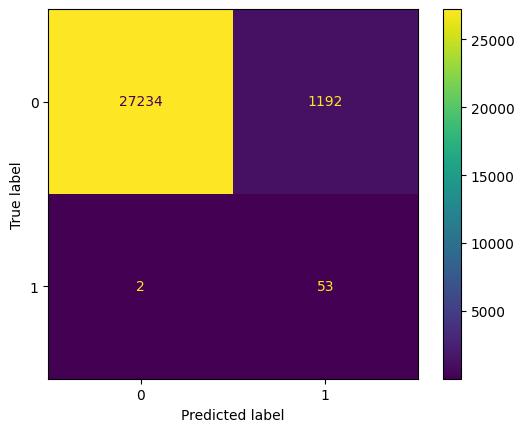

In [21]:
confusion_matrix = metrics.confusion_matrix(test_targets, y_pred_bool)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [22]:
num_positives = np.sum(y_pred_bool == 1)
num_negatives = np.sum(y_pred_bool == 0)

print("تعداد موارد مثبت:", num_positives)
print("تعداد موارد منفی:", num_negatives)

تعداد موارد مثبت: 1245
تعداد موارد منفی: 27236


In [23]:
y_pred_bool

array([0, 0, 0, ..., 1, 0, 0])

In [24]:
y_pred = model.predict(test_features, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(test_targets, y_pred_bool))

446/446 [==============================] - 0s 538us/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28426
           1       0.88      0.82      0.85        55

    accuracy                           1.00     28481
   macro avg       0.94      0.91      0.92     28481
weighted avg       1.00      1.00      1.00     28481



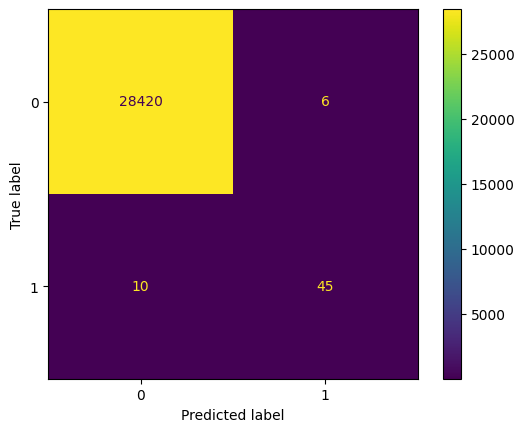

In [25]:
confusion_matrix = metrics.confusion_matrix(test_targets, y_pred_bool)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [26]:
num_positives = np.sum(y_pred_bool == 1)
num_negatives = np.sum(y_pred_bool == 0)

print("تعداد موارد مثبت:", num_positives)
print("تعداد موارد منفی:", num_negatives)

تعداد موارد مثبت: 51
تعداد موارد منفی: 28430
